# Introduction to image classification using camera trap images

Next, let's import some of the usual suspects:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch

In [2]:
# Use CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

In [4]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [5]:
from sklearn.model_selection import train_test_split

frac = 1

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.15
)

In [6]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((14014, 1), (14014, 8), (2474, 1), (2474, 8))

Next, let's validate that our split has resulted in roughly similar relative distributions of species across the train and eval sets (because of how we passed `stratify=y` above).

In [7]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
monkey_prosimian,15,15
antelope_duiker,15,14
civet_genet,14,14
leopard,13,13
blank,13,13
rodent,12,12
bird,9,9
hog,5,5


## 5. Build the Model

### The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None, epoch = 0, eval = False):
        self.data = x_df
        self.label = y_df

        if eval:

            #no transformations but resize
            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),  
                ]
            )

        else:

            if epoch == 1:
                print("Using non-transformed images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])

            elif epoch == 2:
                print("Using grayscale images")
                #greyscale images
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.Grayscale(3),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ]) 
            elif epoch == 3:
                #horizontal flip
                print("Using horizontally flipped images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=1),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
            elif epoch == 4:
                #random tilt
                print("Using random tilt images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
            elif epoch == 5:
                #random colour jitter.
                print("Using colour jitter images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.ColorJitter(0.2,0.2,0.2,0.2),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
                #no transformations but resize
            else:
                print("Using random selection of transformations")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.RandomApply([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(10),
                    ],0.3),
                transforms.RandomApply([
                    transforms.ColorJitter(0.2,0.2,0.2,0.2),
                    transforms.Grayscale(3)
                    ],0.5), 
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
        
                

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [9]:
from torch import nn
import torchvision.models as models


from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=8)

model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to C:\Users\Will Poulett/.cache\torch\hub\checkpoints\efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:02<00:00, 36.6MB/s]


Loaded pretrained weights for efficientnet-b4


### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [10]:
# Send model to GPU
# Send the model to GPU
model = model.to(DEVICE)

In [11]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

num_epochs = 30

#Define loss function

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=num_epochs)

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")
    loss_array = []
    
    train_dataset = ImagesDataset(x_train, y_train, epoch)
    train_dataloader = DataLoader(train_dataset, batch_size=8)

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()
        # 2) run the forward step on this batch of images
        outputs = model(batch["image"].to(DEVICE))
        # 3) compute the loss
        loss = criterion(outputs, batch["label"].to(DEVICE))
        loss_array.append(float(loss))
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)
        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]

    print("SGD lr %.4f -> %.4f" % (before_lr, after_lr))

    print(f"The average loss: {round( (sum(loss_array)/len(loss_array)),3)}")

Starting epoch 1
Using non-transformed images


100%|██████████| 1752/1752 [05:53<00:00,  4.96it/s]


SGD lr 0.0010 -> 0.0010
The average loss: 1.345
Starting epoch 2
Using grayscale images


100%|██████████| 1752/1752 [06:01<00:00,  4.85it/s]


SGD lr 0.0010 -> 0.0009
The average loss: 0.803
Starting epoch 3
Using horizontally flipped images


100%|██████████| 1752/1752 [06:16<00:00,  4.66it/s]


SGD lr 0.0009 -> 0.0009
The average loss: 0.646
Starting epoch 4
Using random tilt images


100%|██████████| 1752/1752 [08:14<00:00,  3.54it/s]


SGD lr 0.0009 -> 0.0009
The average loss: 0.564
Starting epoch 5
Using colour jitter images


100%|██████████| 1752/1752 [08:16<00:00,  3.53it/s]


SGD lr 0.0009 -> 0.0008
The average loss: 0.35
Starting epoch 6
Using random selection of transformations


100%|██████████| 1752/1752 [05:37<00:00,  5.19it/s]


SGD lr 0.0008 -> 0.0008
The average loss: 0.292
Starting epoch 7
Using random selection of transformations


100%|██████████| 1752/1752 [06:51<00:00,  4.25it/s]


SGD lr 0.0008 -> 0.0008
The average loss: 0.23
Starting epoch 8
Using random selection of transformations


100%|██████████| 1752/1752 [06:29<00:00,  4.50it/s]


SGD lr 0.0008 -> 0.0007
The average loss: 0.184
Starting epoch 9
Using random selection of transformations


100%|██████████| 1752/1752 [06:21<00:00,  4.59it/s]


SGD lr 0.0007 -> 0.0007
The average loss: 0.145
Starting epoch 10
Using random selection of transformations


100%|██████████| 1752/1752 [06:33<00:00,  4.46it/s]


SGD lr 0.0007 -> 0.0007
The average loss: 0.131
Starting epoch 11
Using random selection of transformations


100%|██████████| 1752/1752 [06:34<00:00,  4.44it/s]


SGD lr 0.0007 -> 0.0006
The average loss: 0.111
Starting epoch 12
Using random selection of transformations


100%|██████████| 1752/1752 [06:11<00:00,  4.71it/s]


SGD lr 0.0006 -> 0.0006
The average loss: 0.089
Starting epoch 13
Using random selection of transformations


100%|██████████| 1752/1752 [06:12<00:00,  4.70it/s]


SGD lr 0.0006 -> 0.0006
The average loss: 0.08
Starting epoch 14
Using random selection of transformations


100%|██████████| 1752/1752 [05:59<00:00,  4.88it/s]


SGD lr 0.0006 -> 0.0005
The average loss: 0.071
Starting epoch 15
Using random selection of transformations


100%|██████████| 1752/1752 [06:04<00:00,  4.80it/s]


SGD lr 0.0005 -> 0.0005
The average loss: 0.059
Starting epoch 16
Using random selection of transformations


100%|██████████| 1752/1752 [05:53<00:00,  4.96it/s]


SGD lr 0.0005 -> 0.0005
The average loss: 0.058
Starting epoch 17
Using random selection of transformations


100%|██████████| 1752/1752 [05:33<00:00,  5.26it/s]


SGD lr 0.0005 -> 0.0004
The average loss: 0.049
Starting epoch 18
Using random selection of transformations


100%|██████████| 1752/1752 [07:27<00:00,  3.91it/s]


SGD lr 0.0004 -> 0.0004
The average loss: 0.05
Starting epoch 19
Using random selection of transformations


100%|██████████| 1752/1752 [07:53<00:00,  3.70it/s]


SGD lr 0.0004 -> 0.0004
The average loss: 0.047
Starting epoch 20
Using random selection of transformations


100%|██████████| 1752/1752 [06:48<00:00,  4.29it/s]


SGD lr 0.0004 -> 0.0003
The average loss: 0.037
Starting epoch 21
Using random selection of transformations


100%|██████████| 1752/1752 [06:47<00:00,  4.30it/s]


SGD lr 0.0003 -> 0.0003
The average loss: 0.04
Starting epoch 22
Using random selection of transformations


100%|██████████| 1752/1752 [07:04<00:00,  4.12it/s]


SGD lr 0.0003 -> 0.0003
The average loss: 0.037
Starting epoch 23
Using random selection of transformations


100%|██████████| 1752/1752 [06:48<00:00,  4.29it/s]


SGD lr 0.0003 -> 0.0002
The average loss: 0.033
Starting epoch 24
Using random selection of transformations


100%|██████████| 1752/1752 [07:17<00:00,  4.01it/s]


SGD lr 0.0002 -> 0.0002
The average loss: 0.033
Starting epoch 25
Using random selection of transformations


100%|██████████| 1752/1752 [05:50<00:00,  4.99it/s]


SGD lr 0.0002 -> 0.0002
The average loss: 0.031
Starting epoch 26
Using random selection of transformations


100%|██████████| 1752/1752 [05:50<00:00,  4.99it/s]


SGD lr 0.0002 -> 0.0001
The average loss: 0.03
Starting epoch 27
Using random selection of transformations


100%|██████████| 1752/1752 [06:01<00:00,  4.84it/s]


SGD lr 0.0001 -> 0.0001
The average loss: 0.028
Starting epoch 28
Using random selection of transformations


100%|██████████| 1752/1752 [05:59<00:00,  4.87it/s]


SGD lr 0.0001 -> 0.0001
The average loss: 0.029
Starting epoch 29
Using random selection of transformations


100%|██████████| 1752/1752 [05:56<00:00,  4.91it/s]


SGD lr 0.0001 -> 0.0000
The average loss: 0.025
Starting epoch 30
Using random selection of transformations


100%|██████████| 1752/1752 [06:08<00:00,  4.75it/s]

SGD lr 0.0000 -> 0.0000
The average loss: 0.028


Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

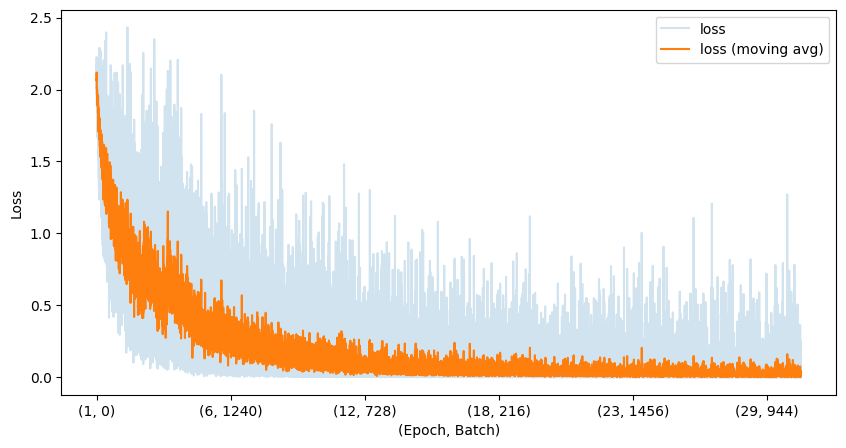

In [12]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

Good news, the loss is going down! This is an encouraging start, especially since we haven't done anything fancy yet.

### Save the model
We have the model loaded in memory already, so we don't really need to save the model, but it's often useful to do this so we can use it again later. 

Here's how:

In [13]:
torch.save(model, "model.pth")

## 7. Evaluation
So far, not so bad. We've shown an improvement in the loss on the training set, but that tells us little about how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [14]:
loaded_model = torch.load("model.pth")

We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

In [15]:
eval_dataset = ImagesDataset(x_eval, y_eval, eval = True)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [16]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"].to(DEVICE))
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1).to(DEVICE)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 78/78 [00:44<00:00,  1.75it/s]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ002535,1.101304e-03,1.251797e-04,9.886092e-01,1.923360e-05,2.066554e-03,8.057927e-03,5.129602e-06,1.545357e-05
ZJ002261,4.482090e-08,9.999943e-01,3.849775e-06,2.872078e-09,2.638224e-08,4.439055e-07,3.873715e-07,9.591158e-07
ZJ011684,3.972766e-07,9.257856e-08,2.242145e-08,1.829741e-08,9.999993e-01,2.401359e-08,1.173508e-07,1.052787e-07
ZJ002061,9.999902e-01,1.953521e-08,2.565697e-07,1.132574e-11,9.164002e-06,7.964544e-09,2.338733e-07,8.722970e-08
ZJ004769,3.828820e-02,5.664549e-06,9.593897e-01,7.187031e-07,5.359811e-07,1.162555e-06,1.523793e-04,2.161626e-03
...,...,...,...,...,...,...,...,...
ZJ014620,3.447804e-09,3.123158e-10,9.999986e-01,5.421961e-10,1.320667e-09,5.168284e-11,1.012738e-06,4.464735e-07
ZJ004289,1.981539e-06,1.862781e-08,4.920333e-09,9.999950e-01,2.938132e-09,1.063010e-07,6.660464e-08,2.802333e-06
ZJ002545,7.185293e-07,9.224321e-11,1.476356e-07,9.999979e-01,1.667907e-08,2.513558e-08,1.839372e-08,1.153039e-06
ZJ010780,1.207044e-06,1.085386e-06,6.058041e-07,9.999946e-01,8.268437e-07,9.944434e-07,7.985739e-09,6.875097e-07


### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [17]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    2118
antelope_duiker     2103
civet_genet         2059
leopard             1916
blank               1881
rodent              1711
bird                1395
hog                  831
dtype: int64

Here's the distribution of our predictions on the eval set. 

In [18]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    371
civet_genet         368
leopard             336
rodent              330
blank               329
antelope_duiker     320
bird                258
hog                 162
dtype: int64

The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [19]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    374
antelope_duiker     371
civet_genet         364
leopard             338
blank               332
rodent              302
bird                246
hog                 147
dtype: int64

### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [20]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ002535              blank
ZJ002261               bird
ZJ011684                hog
ZJ002061    antelope_duiker
ZJ004769              blank
dtype: object

In [21]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.15117219078415522

In [22]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.902586903799515

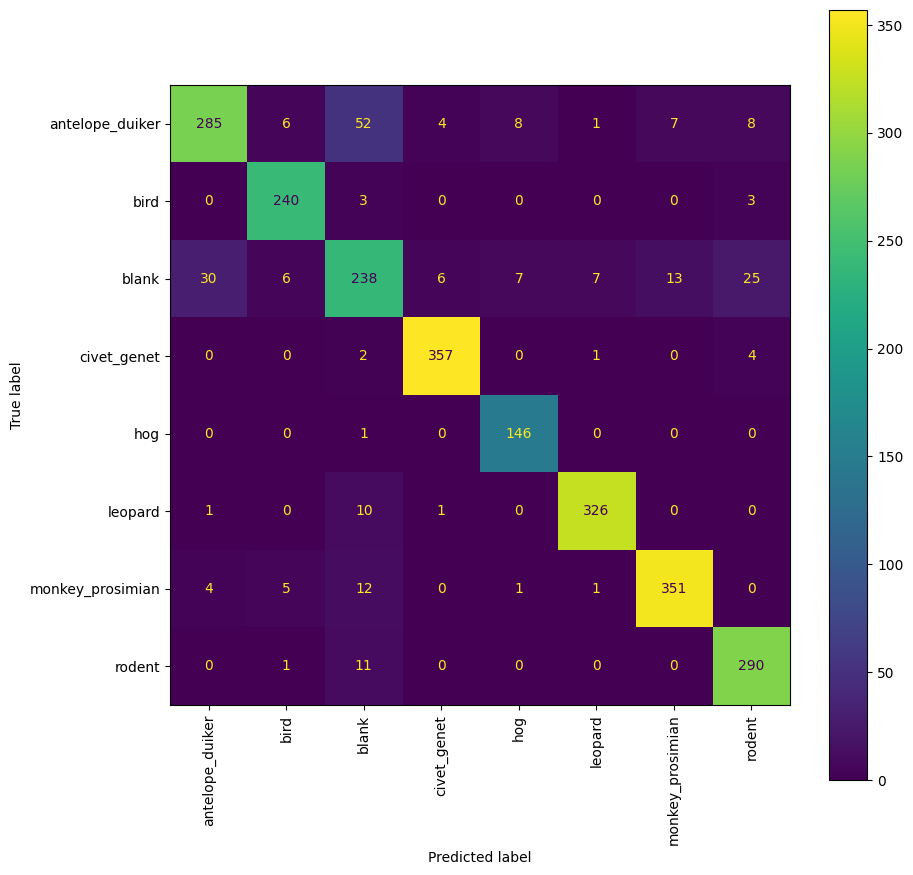

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

That's where you come in! What can you do to improve on this benchmark?

Here are some ideas you might want to try:
* Train on the full training dataset. We've only used 50% of the training data so far.
* Train for more epochs. We've only done 1 so far.
* Try another pretrained model. For example, you may have more success with EfficientNet, or another ResNet model with more layers like ResNet152. See what's available from pytorch [here](https://pytorch.org/vision/stable/models.html). You may also want to review which models are or have been state of the art for image classification tasks, for example on [paperswithcode.com](https://paperswithcode.com/task/image-classification). Keep in mind that different models will require different input and output dimensions, so you'll need to update how you construct `model` above.
* Experiment with different loss functions.
* Experiment with different learning rates or learning rate schedulers.
* Add more layers to the model head (`model.fc`).
* You also may want to consider freezing the weights in the backbone model and only training the head (`model.fc`). If this results in higher accuracy, that suggests the current approach may be overwriting the backbone weights in a problematic way. One approach here would be to train just the model head, and then unfreeze the backbone but train at a lower learning rate.
* Training will be much faster using GPUs, but you will need to make some small tweaks to the code.
* As you become more comfortable iterating through different versions of the model, you may want to try out [PyTorch Lightning](https://www.pytorchlightning.ai/) or [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/quickstart.html), which build upon PyTorch and eliminate a lot of boilerplate code, in addition to providing a more complete research framework for deep learning problems.

## 8. Create submission

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [24]:
test_dataset = ImagesDataset(test_features.filepath.to_frame())
test_dataloader = DataLoader(test_dataset, batch_size=32)

Using random selection of transformations


In [25]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval().to("cpu")

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # run the forward step
        logits = model.forward(batch["image"])
        # apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

submission_df = pd.concat(preds_collector)
submission_df

100%|██████████| 140/140 [40:17<00:00, 17.27s/it]  


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.000004,4.892845e-07,3.066915e-01,6.926582e-01,2.278872e-07,4.683493e-05,9.507437e-08,0.000599
ZJ016489,0.002886,9.955721e-01,8.023537e-05,1.578072e-04,1.240442e-03,4.971149e-07,1.877068e-05,0.000045
ZJ016490,0.861248,2.055898e-03,1.063651e-03,1.186607e-03,1.334636e-01,1.087229e-05,1.803204e-04,0.000791
ZJ016491,0.000008,2.067670e-04,8.948842e-07,1.156850e-05,1.581940e-03,9.981167e-01,2.422663e-05,0.000050
ZJ016492,0.003909,2.909952e-01,5.699399e-01,6.104863e-06,3.339576e-03,4.522298e-04,8.372848e-02,0.047629
...,...,...,...,...,...,...,...,...
ZJ020947,0.136181,5.322139e-01,4.099782e-02,7.745533e-05,2.273546e-01,5.337453e-04,2.924960e-02,0.033392
ZJ020948,0.013861,3.783234e-03,9.807938e-01,7.658105e-06,3.615679e-04,5.686590e-05,5.796285e-04,0.000557
ZJ020949,0.006030,8.210252e-05,9.143159e-01,6.954315e-02,9.966805e-03,5.030610e-05,8.202633e-06,0.000004
ZJ020950,0.999056,7.589620e-04,2.243078e-08,2.082408e-07,9.615544e-05,8.307366e-07,8.513978e-05,0.000003


Let's check a couple things on `submission_df` before submitting to the platform. We'll want to make sure our submission's index and column labels match the submission format. (The DrivenData platform will do these data integrity checks as well, but it will be quicker to detect problems this way.)

In [26]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.

In [27]:
submission_df.to_csv("submission_df.csv")

How did we do? We should get a score of ~1.8, though your results may differ slightly due to non-determinism in model training. (For reference, a randomly generated submission yields a score of something like ~2.4.)

![benchmark submission](https://drivendata-public-assets.s3.amazonaws.com/conservision-benchmark-score.jpg)

Now it is up to you to improve on this benchmark!

Head over to the [competition](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) for data and more background info, or the [competition forum](https://community.drivendata.org/c/conser-vision/87) if you have any questions. Good luck!